In [ ]:
import json
import numpy as np

firs = ""

with open('fir.json', 'r') as f:
    firs = json.load(f)

# for every entry check NAME and coordinates of FIR
for fir in firs['features']:
    name = "FIR"+fir['properties']['name']
    # extract all coordinates for
    coords = fir['geometry']['coordinates'][0]
    arr = np.array(coords)
    arr.T[[0,1]] = arr.T[[1,0]]
    c = np.round(arr.flatten(),4)
    print(' '.join(map(str,c)))
    print(name, end=' ')
    # print(np.array2string(c)[1 : -1])
    print(np.array2string(np.round(arr.flatten(),4))[1 : -1])

# print(json.dumps(firs, indent=4, sort_keys=True))

In [3]:
from readflights import ReadFlights
import sys

rf = ReadFlights()
rf.openPKL(fileName = "../../../localdata/t_future_flas_240_fra_01.pkl", nMax=sys.maxsize)

In [6]:
df = rf.df[rf.df['time'].between(0, 60*60*24)]
df


,id,time,altitude,longitude,latitude,dist,dir,speed,id_
date,,,,,,,,,
1977-11-11 00:03:18+00:00,SIA37A,198,13222,104.58319,1.16676,89.477311,268.711504,183.212730,1
1977-11-11 00:04:37+00:00,SIA37A,277,11098,104.45303,1.16383,14.473806,265.805561,153.200846,1
1977-11-11 00:08:43+00:00,SIA37A,523,5466,104.11494,1.13902,37.687408,265.831965,125.554678,1
1977-11-11 00:10:14+00:00,SIA37A,614,3790,104.01244,1.13155,11.425476,284.505463,117.443448,1
1977-11-11 00:10:25+00:00,SIA37A,625,3592,104.00119,1.13446,1.291878,326.558803,115.226559,1
...,...,...,...,...,...,...,...,...,...
1977-11-11 23:57:59+00:00,MXD7604B,86279,0,101.69778,2.74306,0.000000,69.584834,155.981369,4139
1977-11-11 23:59:06+00:00,AHK317A_,86346,0,113.91500,22.30889,0.000000,209.037414,141.235170,4140
1977-11-11 23:59:11+00:00,SIA319B_,86351,0,-0.46167,51.47056,0.000000,78.129366,151.473793,4141


In [8]:
print(len(rf.getFlightList()))

flight = rf.getFlight('SIA37A')
# flightResample = rf.resample('SIA37A', sampleTime='20s')

flight


18588


,id,time,altitude,longitude,latitude,dist,dir,speed,id_
date,,,,,,,,,
1977-11-10 08:08:39+00:00,SIA37A,-57081,0,-118.40778,33.94250,0.000000,299.619187,152.683148,1
1977-11-10 08:16:51+00:00,SIA37A,-56589,17401,-119.11849,34.27435,75.120109,299.219134,225.491811,1
1977-11-10 08:22:48+00:00,SIA37A,-56232,26144,-119.88633,34.62536,80.500577,298.782413,248.954429,1
1977-11-10 08:29:52+00:00,SIA37A,-55808,33193,-120.90301,35.07822,105.556678,298.198714,249.169372,1
1977-11-10 08:33:15+00:00,SIA37A,-55605,35876,-121.39418,35.29218,50.581383,297.915965,247.328025,1
1977-11-10 08:35:44+00:00,SIA37A,-55456,37235,-121.75366,35.44681,36.851876,297.705506,247.420204,1
1977-11-10 08:38:36+00:00,SIA37A,-55284,38377,-122.17051,35.62403,42.556275,297.463062,247.579686,1
1977-11-10 08:41:47+00:00,SIA37A,-55093,39270,-122.63587,35.81926,47.287720,297.189776,247.532197,1
1977-11-10 08:45:25+00:00,SIA37A,-54875,40000,-123.16971,36.03983,53.962019,296.637388,247.571139,1


In [8]:
df = rf.df

df

,id,time,altitude,longitude,latitude,dist,dir,speed
date,,,,,,,,
1977-11-10 08:08:39+00:00,SIA37A,-57081,0,-118.40778,33.94250,0.000000,299.619187,152.683148
1977-11-10 08:16:51+00:00,SIA37A,-56589,17401,-119.11849,34.27435,75.120109,299.219134,225.491811
1977-11-10 08:22:48+00:00,SIA37A,-56232,26144,-119.88633,34.62536,80.500577,298.782413,248.954429
1977-11-10 08:29:52+00:00,SIA37A,-55808,33193,-120.90301,35.07822,105.556678,298.198714,249.169372
1977-11-10 08:33:15+00:00,SIA37A,-55605,35876,-121.39418,35.29218,50.581383,297.915965,247.328025
...,...,...,...,...,...,...,...,...
1977-11-16 06:34:36+00:00,SIA265F,455676,24736,151.56905,-26.79407,94.392850,113.532140,197.622318
1977-11-16 06:42:42+00:00,SIA265F,456162,10318,152.45892,-27.13615,96.044447,113.128055,143.996375
1977-11-16 06:47:35+00:00,SIA265F,456455,4061,152.85154,-27.28464,42.190938,112.948252,113.964157


ValueError: left cannot be >= right

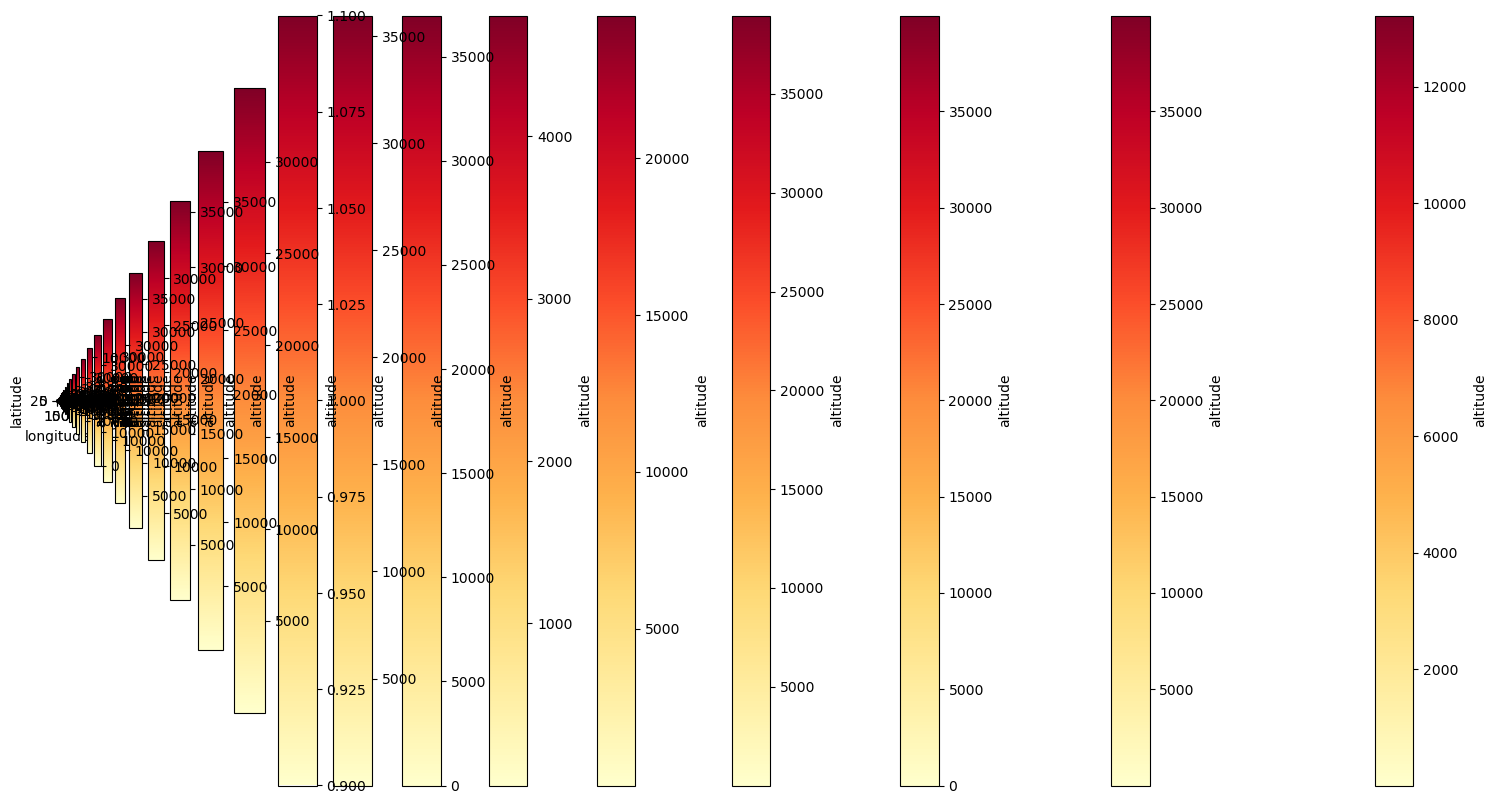

In [9]:
from readflights import ReadFlights
import sys

rf = ReadFlights()
rf.openPKL(fileName = "../../../localdata/t_future_flas_240_fra_01.pkl", nMax=sys.maxsize)

# rf.plotFlights(rf.getFlightList()[:20000], time=([3600*10, 3600*12])) #, flightResample)

day = 4
df = rf.df[rf.df['time'].between(86400*day + 0, 86400*day + 60*60*24)]

rf.plotFlights(list, df = df)

day = 2
df = rf.df[rf.df['time'].between(86400*day + 0, 86400*day + 60*60*24)]

rf.plotFlights(list, df = df)


In [35]:
import rdp as RDP
import numpy as np


pos = np.array([
    [1,1], 
	[2,2],
	[3,3],
	[7,27],
	[10,10]
	])

anchors = [0, len(pos)-1]

RDP.simplify(pos, .1, anchors)

print(anchors)

[0, 2, 3, 4]


In [15]:

# provides distance in m
def mercator(lats, lons):
    r_major = 6378137.000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return (x, y)

lats = np.asarray([63])
lons = np.asarray([179])

# lats = df['latitude'].values
# lons = df['longitude'].values

xs, ys = mercator(lats, lons)
# # df['latitude'].values

# df



print('xs: {}'.format(xs))  # => [-355520.27851004 -244902.8797452 ]
print('ys: {}'.format(ys))  # => [ 7358781.82857011  7558415.65608178]

# df

xs: [19926188.85199597]
ys: [9100250.90705955]


In [16]:
import pyproj
from pyproj import Transformer

# wgs84 =pyproj.CRS("EPSG:4326")
# merc  =pyproj.CRS("EPSG:3857")
# isn2004=pyproj.CRS("+proj=lcc +lat_1=64.25 +lat_2=65.75 +lat_0=65 +lon_0=-19 +x_0=1700000 +y_0=300000 +no_defs +a=6378137 +rf=298.257222101 +to_meter=1") 
 

lat = [63]   # x
lon = [179]  # y

wgs2merc = Transformer.from_crs("epsg:4326", "epsg:3857")
x, y = wgs2merc.transform(lat, lon)

print(x)
print(y)

merc2wgs = Transformer.from_crs("epsg:3857", "epsg:4326")
lat, lon = merc2wgs.transform(x, y)

print(lat)
print(lon)

[19926188.85199597]
[9100250.907059548]
[63.0]
[179.0]


In [3]:
import rdp as RDP
import lzma
import pandas as pd
import numpy as np
from io import StringIO
from pyproj import Transformer

n = 0
header = ""
oldId = ""
csv = ""

dfs = ""
dfs_raw = ""

wgs2merc = Transformer.from_crs("epsg:4326", "epsg:3857")
merc2wgs = Transformer.from_crs("epsg:3857", "epsg:4326")

with lzma.open("c:\\Users\\mschultz\\Downloads\\t_future_flas_360_ats_01.csv.xz", mode='rt', encoding='utf-8') as file:
    for line in file:
        id = line.split(sep=",")[0]
        if oldId != id:
            if(n > 1):  # ignore header
                print(header.split(sep=","))
                # print(csv)
                csvStringIO = StringIO(csv)
                df = pd.read_csv(csvStringIO, sep=",", header=None, names=header.split(sep=","))

                # df.to_csv("SIA.csv")

                # check for later: https://github.com/SciTools/cartopy/issues/368
                # https://stackoverflow.com/questions/65872151/geopandas-how-to-output-longitude-latitude-scale-correctly-in-mercator-projeti
                # df['latitude_m'], df['longitude_m'] = wgs2merc.transform(df['latitude'], df['longitude'])

                # check weather flight is going over pacific
                isCross = abs(df['longitude'].values[0] - df['longitude'].values[-1]) > 180

                # create a reference set
                # TODO: correct data should indicate dateline change, isCross should not be necessary
                # if isCross:
                #     pos = df[df['longitude'] <= 0][['latitude','longitude']].to_numpy()
                #     anchors = RDP.simplify(pos, 0.00001, [0, len(pos)-1])
                #     offSet = df[df['longitude'] > 0].index[0]
                #     pos = df[df['longitude'] > 0][['latitude','longitude']].to_numpy()
                #     anchors.extend(RDP.simplify(pos, 0.00001, [0, len(pos)-1])+offSet)
                #     # print (anchors)
                # else:
                #     pos = df[['latitude','longitude']].to_numpy()
                #     anchors = RDP.simplify(pos, 0.00001, [0, len(pos)-1])
                # dfs_raw = df.loc[anchors] # 0.00001


                # simplify altitudes first, 25ft
                pos = df[['time','altitude']].to_numpy()
                anchors = RDP.simplify(pos, 25, [0, len(pos)-1])  

                # next step is simplify for distances, 200m
                # 0°: 1° => 111,13 km
                # 60°: 1° => 55,57 km
                # 0.003° set as equivalent for 200m
                # using lat and lon (degrees) by purpose, may be changed to mercator later
                pos = df[['latitude','longitude']].to_numpy()
                anchors = RDP.simplify(pos, .003 , anchors) # .003
                dfs = df.loc[anchors]


                break
            elif(n == 0):
                # add header without \\\ at the end
                header = str(line[:-1])
            csv = ""
            n += 1
        csv += str(line)

        oldId = id


['id', 'time', 'altitude', 'longitude', 'latitude']


In [4]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 7))

chart = sns.lineplot(
    x="longitude",
    y="latitude",
    marker = '.',
    linestyle='',
    data=dr
).set_title('Flight')

chart = sns.lineplot(
    x="longitude",
    y="latitude",
    marker = 'o',
    linestyle='',
    data=dfs
).set_title('Flight')

# plt.xlim(95,120)
# plt.ylim(-5,10)

plt.show();

c:\Users\mschultz\anaconda3\envs\atmri_caas\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'dr' is not defined

<Figure size 1080x504 with 0 Axes>

In [38]:
import geopandas

In [8]:
dfs

,id,time,altitude,longitude,latitude,latitude_m,longitude_m
0,SIA37A,-57081,0,-118.40778,33.94250,-1.318109e+07,4.021084e+06
492,SIA37A,-56589,17401,-119.11849,34.27435,-1.326021e+07,4.065700e+06
849,SIA37A,-56232,26144,-119.88633,34.62536,-1.334569e+07,4.113085e+06
1273,SIA37A,-55808,33193,-120.90301,35.07822,-1.345886e+07,4.174516e+06
1476,SIA37A,-55605,35876,-121.39418,35.29218,-1.351354e+07,4.203658e+06
1625,SIA37A,-55456,37235,-121.75366,35.44681,-1.355356e+07,4.224768e+06
1797,SIA37A,-55284,38377,-122.17051,35.62403,-1.359996e+07,4.249011e+06
1988,SIA37A,-55093,39270,-122.63587,35.81926,-1.365176e+07,4.275780e+06
2206,SIA37A,-54875,40000,-123.16971,36.03983,-1.371119e+07,4.306103e+06
50985,SIA37A,-6096,39982,115.88247,8.96816,1.289998e+07,1.002433e+06


In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 7))

chart = sns.lineplot(
    x="time",
    y="altitude",
    marker = '.',
    linestyle='',
    data=dr
).set_title('Flight')

chart = sns.lineplot(
    x="time",
    y="altitude",
    marker = 'o',
    linestyle='',
    data=df
).set_title('Flight')

# plt.xlim(95,120)
# plt.ylim(-5,10)

plt.show()

NameError: name 'dr' is not defined

<Figure size 1500x700 with 0 Axes>

In [10]:
dfs

# resample https://kanoki.org/2020/04/14/resample-and-interpolate-time-series-data/
# https://stackoverflow.com/questions/41854578/using-pandas-dataframe-interpolate-to-add-rows-to-dataframe#comment70893217_41854682


NameError: name 'dfs' is not defined

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

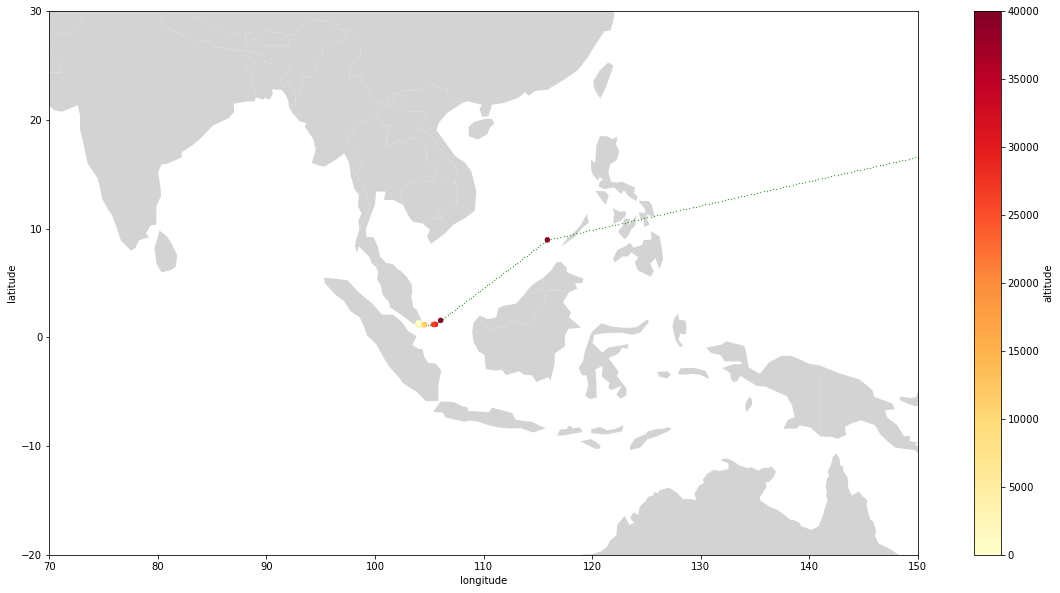

In [7]:
from itertools import count
import geopandas as gp


# initialize an axis
fig, ax = plt.subplots(figsize=(20,10))

ax.set(xlim=(70,150), ylim=(-20, 30))
# ax.set(xlim=(90,130), ylim=(-15, 25))

countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

dr.plot(x="longitude", y="latitude", kind="scatter", c = "green", s=.1, ax=ax)
df.plot(x="longitude", y="latitude", kind="scatter", c="altitude", colormap= "YlOrRd", ax=ax)

# fig_size = (10, 5)
# f = plt.figure(figsize=fig_size)

# def plot_signal(time, signal, title='', xlab='', ylab='',
#                 line_width=1, alpha=1, color='k',
#                 subplots=False, show_grid=True, fig=f):

#     # Skipping a lot of other complexity here

#     axarr = f.add_subplot(1,1,1) # here is where you add the subplot to f
#     plt.plot(time, signal, linewidth=line_width,
#                alpha=alpha, color=color)
#     plt.set_xlim(min(time), max(time))
#     plt.set_xlabel(xlab)
#     plt.set_ylabel(ylab)
#     plt.grid(show_grid)
#     plt.title(title, size=16)
    
#     return(f)
# f = plot_signal(time, signal, fig=f)
# f

In [1]:
from pyproj import Transformer
wgs2merc = Transformer.from_crs("epsg:4326", "epsg:3857")
merc2wgs = Transformer.from_crs("epsg:3857", "epsg:4326")

sampleTime = "120s"

# get a copy of simplified dataframe
dr = dfs.copy()

# set a give date to transform seconds to timestamp
ddt = 248054400   # 11.11.77 just for fun

# create a new column to store time (s) as date
dr['date'] = pd.to_datetime(dr['time']+ddt, unit='s', utc=True)

# set date as index to allow for interpolation
dr = dr.set_index('date')

# resample the original dataframe
# column ['id'] was deleted: --> non-numerical columns are removed in resample.
dr_ = dr.resample(sampleTime).mean()

# it makes no sence for interpolation of these values
dr_ = dr_.drop(['speed','dir'], axis = 1)

# consider shortes way is via pacific by checking longitudinal distance
isLeft = abs(dr_['longitude'].max() - dr_['longitude'].min()) > 180

# change longitudinal coordinates ensuring correct interpolation
if isLeft:
    dr_['longitude'] = [ 360 + x if x < 0 else x for x in dr_['longitude']]
    dr_ = dr_.interpolate('linear')
    dr_['longitude'] = [ x - 360 if x > 180 else x for x in dr_['longitude']]

    # find closest point to dateline an add to dataset
    dr_= pd.concat(
        [ dr_, 
          # dr_[dr_['longitude'] == dr_['longitude'].min()], 
          dr_.loc[[str(dr_['longitude'].idxmin())]],   # [[]] double [[ is important
          dr_[dr_['longitude'] == dr_['longitude'].max()]
        ]
        ).sort_index()
    


    dr_['latitude'], dr_['longitude'] = wgs2merc.transform(dr_['latitude'], dr_['longitude'])

    # cut the dataset in east and west
    east  = dr_.loc[ : dr_['longitude'].diff().idxmax()][:-1]
    west  = dr_.loc[dr_['longitude'].diff().idxmax() : ]

    east = east.resample(sampleTime).mean()
    west = west.resample(sampleTime).mean()
    
    east = east.interpolate('linear')
    west = west.interpolate('linear')

    dr_ = pd.concat([east, west])
    dr_['latitude'], dr_['longitude'] = merc2wgs.transform(dr_['latitude'], dr_['longitude'])
    
else:
    dr_['latitude'], dr_['longitude'] = wgs2merc.transform(dr_['latitude'], dr_['longitude'])
    dr_ = dr_.resample(sampleTime).mean()
    dr_['latitude'], dr_['longitude'] = merc2wgs.transform(dr_['latitude'], dr_['longitude'])

# remove all entry created, which are before first occurance and after last occurance
dr_ = dr_.loc[dr.index[0]:dr.index[-1]]

# join datasets
dr = pd.concat([dr, dr_]).sort_index()

dr = dr.ffill()



dr

NameError: name 'dfs' is not defined

In [5]:
# vectorized haversine function
def distance(lat1: list, lon1: list, lat2 : list = None, lon2 : list = None) -> list:

    if lat2 is None:
        # lat = lat1.shift()
        # lon = lon1.shift()
        # lat2 = lat1[1:]
        # lon2 = lon1[1:]
        # lat1 = lat
        # lon1 = lon
        lat2 = lat1
        lon2 = lon1
        lat1 = lat1.shift()
        lon1 = lon1.shift()

    # for a,b,c,d in zip(lat1, lon1, lat2, lon2):
    #     print(str(a) + "\t" + str(b) + "\t" + str(c) + "\t" + str(d))

    # to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # pre calculation
    dLat = lat2-lat1
    dLon = lon2-lon1

    # normalized distance
    a = np.sin(dLat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2.0)**2

    # first value form NAN to 0
    a[0] = 0
    earth_radius = 6371

    # calculate distance
    dist = earth_radius * 2 * np.arcsin(np.sqrt(a))

    # calculate bearing 
    x = np.sin(dLon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dLon))
    brng = np.arctan2(x, y)
    brng = np.rad2deg(brng)
    
    # compass_bearing
    brng = ((brng) + 360) % 360  

    # set as course, fill NAN with 0 -- last row
    brng = brng.shift(-1).fillna(0)

    return dist, brng



def sec2time(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
#    print("seconds value in hours:",hour)
#    print("seconds value in minutes:",min)
   return "%02d:%02d:%02d" % (hour, min, sec) 


dff = dfs

# dff['dist'] = distance(dff['latitude'].shift(), dff['longitude'].shift(), dff.loc[1:, 'latitude'], dff.loc[1:, 'longitude'])


dff['dist'], dff['dir'] = distance(dff['latitude'], dff['longitude'])

# set speed as value to achieve the distance before. Thus speed now contains the speed needed for the next leg.
dff['speed'] = (dff['dist']/dff['time'].diff()*1000).shift(-1).fillna(0)

# print(dff)

# find row which meets the criteria
f = dff[dff['time'] > 0].index[0]
# store all index in a list
indexList = dff.index.values.tolist()
# find row before -- take row 1 as minimum, since row 0 has no speed
i = max(1, indexList.index(f) - 1)
# access row and store at single list

d = dff.iloc[[i]].values.flatten().tolist()

# print(d)

# CRE acid type lat lon hdg alt spe
# CRE SIA37A A350 1.196620 105.570520 268.3 29798 247.4
dt = d[1]
print( str(sec2time(0))+">CRE", d[0], "A350 %5.6f %5.6f %5.1f %5.0f %5.1f" % (d[4], d[3], d[6], d[2], d[7]))

# https://github.com/TUDelft-CNS-ATM/bluesky/wiki/addwpt
# The speed at each waypoint is the speed for the leg towards this waypoint.
# 00:00:01.11>ADDWPT,AC0001,-3.24887465,-2.77108288,0.0,450.00000000

# all other postions are taken as waypoints
for c in range(i+1, len(indexList)):
    d = dff.iloc[[c]].values.flatten().tolist()
    print(str(sec2time(0))+">ADDWPT", d[0], "%5.6f %5.6f %5.1f %5.1f" % (d[4], d[3], d[2], d[7]))

# dff



00:00:00>CRE SIA37A A350 1.185770 105.381660 268.6 26566 204.4
00:00:00>ADDWPT SIA37A 1.166530 104.573090 13053.0 183.0
00:00:00>ADDWPT SIA37A 1.163830 104.452950 11096.0 152.9
00:00:00>ADDWPT SIA37A 1.138760 104.111300 5405.0 125.3
00:00:00>ADDWPT SIA37A 1.131550 104.012400 3790.0 116.7
00:00:00>ADDWPT SIA37A 1.135680 103.999390 3556.0 115.8
00:00:00>ADDWPT SIA37A 1.150270 103.991350 3280.0 112.3
00:00:00>ADDWPT SIA37A 1.235110 103.990430 1920.0  83.3
00:00:00>ADDWPT SIA37A 1.358780 103.989170   4.0   0.0
